In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
torch.set_default_dtype(torch.float64)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

#-------------------------------------
#-----     Utility functions     -----
#-------------------------------------

def moving_average(a, n=1000):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Introduction to Physics-Informed Neural Networks

$$
\left\{
\begin{aligned}
    & u_t + u \cdot u_x - \nu u_{xx} = 0 \\
    & x \in \left[ -1, 1 \right], \quad t \in \left[0, 1 \right], \\
    & u(0, x) = -\sin(\pi x) \\
    & u(t, -1) = u(t, 1) = 0.
\end{aligned}
\right.
$$

In [2]:
class MLP(nn.Module):
    """
    Simple implementation of a Multi-Layer Perceptron in PyTorch.

    INPUT
    -----

    layers : list of integers.
             The number of layers is determined from the length of the list.
             The i-th element layers[i] determines the number of neuron in the i-th layer.

    activation : From torch.nn
                 Activation function used for each layer (except the last one).
    """
    def __init__(self, layers, activation=torch.nn.Sigmoid):
        # --> Initialize base class.
        super(MLP, self).__init__()
        # --> Setup the activation function.
        self.activation = activation
        # --> Setup the network's architecture.
        depth = len(layers) - 1 ; layers_list = list()
        # Input and hidden layers.
        for i in range(depth-1):
            # Layer's topology.
            layers_list.append(("Layer_{0}".format(i), torch.nn.Linear(layers[i], layers[i+1])))
            # Layer's activation function.
            layers_list.append(("Activation_{0}".format(i), self.activation()))
        # Output layer.
        layers_list.append(("Output", torch.nn.Linear(layers[-2], layers[-1])))
        # Builds MLP
        layers = OrderedDict(layers_list)
        self.net = torch.nn.Sequential(layers)
        # Initialize weights.
        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
        self.net.apply(init_weights)

    def forward(self, x):
        return self.net(x)

In [3]:
class PINN():
    """
    Implementation of a simple Physics-Informed Neural Network method in PyTorch to solve the
    one-dimensional unsteady heat equation with homogeneous Dirichlet boundary conditions.

    INPUT
    -----

    params : dict
             Dictionary of parameters for the PDE and the Monte-Carlo samplers.

    initial_condition : function
                        Function with interface foo(x, params) evaluating the initial condition of the problem.

    sampler : dictionary of functions
              Contains the samplers associated to each term in the objective function.

    layers : list of integers
             Architecture of the Multi-Layer Perceptron used to represent the solution of the PDE.

    λ      : Non-negative float between 0 and 1.
             Parameter for the convex combination of the different terms in the objective function.

    loss   : From torch.nn
             Loss function used to define the objective function of the PINN.
    """
    def __init__(self, params, initial_condition, sampler, layers, λ=0.5, loss=torch.nn.MSELoss()):
        # Whether CPU or GPU is being used.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # --> Parameters of the PDE.
        self.params = params
        # --> Initial condition of the PDE.
        self.initial_condition = initial_condition
        # --> Sampler for the Monte-Carlo integration.
        self.sampler = sampler
        # --> Neural network representation of the PDE solution.
        self.dnn = MLP(layers).to(self.device)
        # --> Set up the optimizer.
        self.loss_function = loss ; self.λ = λ
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr = 0.01)
        # --> Containers for the time-history of the different loss terms.
        self.pde_loss = list()
        self.bc_loss = list()
        self.ic_loss = list()
        self.total_loss = list()

    def u(self, x, t):
        return self.dnn(torch.cat([x[:, None], t[:, None]], dim=1))

    def residual(self, x, t):
        # --> Solution of the PDE.
        u = self.u(x, t)

        # --> Time-derivative.
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused = True
        )[0]

        # --> First-derivative in space.
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused = True
        )[0]

        # --> Second derivative in space.
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused = True
        )[0]

        # --> Residual of the PDE.
        r = u_t - self.params["kappa"]*u_xx
        
        return r

    def loss(self):
        # --> Re-initialize optimizer's gradient.
        self.optimizer.zero_grad()

        # --> Sample boundary points.
        tb1 = self.sampler["boundary conditions"](self.params); tb1 = tb1.to(device=self.device, dtype=torch.double) ; tb1.requires_grad = True
        u_bc_1 = self.u(torch.zeros_like(tb1), tb1)
        tb2 = self.sampler["boundary conditions"](self.params); tb2 = tb2.to(device=self.device, dtype=torch.double) ; tb2.requires_grad = True
        u_bc_2 = self.u(L*torch.ones_like(tb2), tb2)

        # --> Sample initial condition.
        xic = self.sampler["initial condition"](self.params) ; xic = xic.to(device=self.device, dtype=torch.double) ; xic.requires_grad = True
        u_ic = self.u(xic, torch.zeros_like(xic))
        u_ic_true = self.initial_condition(xic, params["L"]).double().to(self.device)

        # --> Sample interior of the spatio-temporal domain.
        x_residual, t_residual = self.sampler["residual"](self.params)
        x_residual = x_residual.to(device=self.device, dtype=torch.double) ; t_residual = t_residual.to(device=self.device, dtype=torch.double)
        x_residual.requires_grad = True ; t_residual.requires_grad = True
        residual = self.residual(x_residual, t_residual)

        # --> Compute the loss function.
        loss_pde = self.loss_function(residual, torch.zeros_like(residual))
        loss_ic  = self.loss_function(u_ic, u_ic_true[:, None])
        loss_bc  = self.loss_function(u_bc_1, torch.zeros_like(u_bc_1)) + self.loss_function(u_bc_2, torch.zeros_like(u_bc_2))
        total_loss = (1 - self.λ) * loss_pde + self.λ * (loss_ic + loss_bc)
        total_loss.backward()

        self.pde_loss.append(loss_pde.item()) ; self.bc_loss.append(loss_bc.item()) ; self.ic_loss.append(loss_ic.item())
        self.total_loss.append(total_loss.item())
        
        return total_loss

    def train(self):
        self.dnn.train()
        for _ in tqdm(range(1_000)):
            self.optimizer.step(self.loss)

        self.pde_loss = np.asarray(self.pde_loss)
        self.ic_loss = np.asarray(self.ic_loss)
        self.bc_loss = np.asarray(self.bc_loss)

    def predict(self, x, t):
        self.dnn.eval()
        x = torch.tensor(x, requires_grad=True).float().to(self.device)
        t = torch.tensor(t, requires_grad=True).double().to(self.device)
        u = self.u(x, t) ; r = self.residual(x, t)
        u, r = u.detach().cpu().numpy(), r.detach().cpu().numpy()
        return u, r

In [4]:
def bc_sampler(params):
    t = torch.rand(params["nbc"]) * params["tau"]
    return t

def ic_sampler(params):
    x = torch.rand(params["nic"]) * params["L"]
    return x    

def domain_sampler(params):
    collocation_pts = torch.rand(params["nr"], 2)
    return collocation_pts[:, 0]*params["L"], collocation_pts[:, 1]*params["tau"]

sampler = {"boundary conditions": bc_sampler,
           "initial condition"  : ic_sampler,
           "residual"           : domain_sampler
          }    

In [5]:
# Physical parameters.
κ = 1.0      # Diffusion coefficient.
L = 1.0      # Size of the domain.
τ = L**2 / κ # Integration time.

# Initial condition.
initial_condition = lambda x, L: torch.sin(np.pi*x/L)

# Number of samples to evaluate the integrals (uniform sampling).
nbc = 128    # Evaluate the boundary conditions.
nic = 128    # Evaluate the initial condition.
nr  = 512 # Evaluate the residual of the PDE.

# Architecture of the network used to represent the solution of the PDE.
layers = [2, 5, 5, 1]

# Phyiscs-Informed Neural Network.
params = {
    "kappa" : κ,
    "L"     : L,
    "tau"   : τ,
    "nbc"   : nbc,
    "nic"   : nic,
    "nr"    : nr
}
pinn = PINN(params, initial_condition, sampler, layers)

/home/loiseau/miniconda3/envs/larochelle/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
%%time
pinn.train()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.41it/s]

CPU times: user 29 s, sys: 263 ms, total: 29.3 s
Wall time: 4.78 s


In [7]:
nx, nt = 128, 256
x, t = np.linspace(0, L, nx), np.linspace(0, τ, nt)
x, t = np.meshgrid(x, t)

u, r = pinn.predict(x.flatten(), t.flatten())
u = u.reshape(nt, nx)

[(0.0, 1.0),
 Text(0, 0.5, 'Time $t$'),
 [Text(0, 0.0, '$0$'), Text(0, 1.0, '$\\tau$')]]

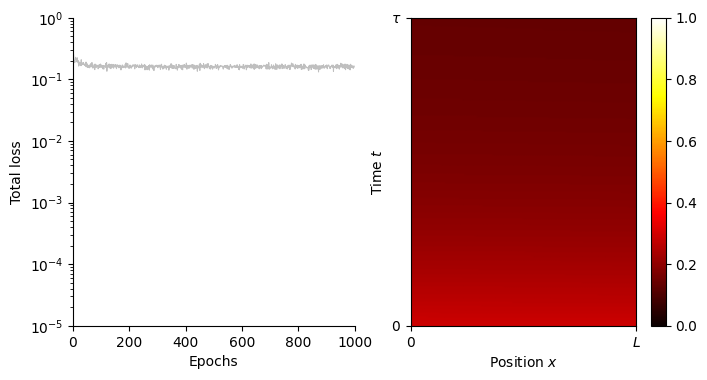

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].semilogy(pinn.total_loss, lw=0.75, color="gray", alpha=0.5)
axes[0].semilogy(moving_average(pinn.total_loss), lw=0.75)
axes[0].set(xlim=(0, len(pinn.total_loss)), xlabel=r"Epochs", 
            ylim=(1e-5, 1), ylabel=r"Total loss")
axes[0].spines[["top", "right"]].set_visible(False)

pcm = axes[1].pcolormesh(x, t, u, shading="gouraud", cmap="hot", vmin=0, vmax=1)
fig.colorbar(pcm, ax=axes[1])

axes[1].set(xlim=(0, 1), xlabel=r"Position $x$", xticks=[0, L], xticklabels=[r"$0$", r"$L$"])
axes[1].set(ylim=(0, τ), ylabel=r"Time $t$", yticks=[0, τ], yticklabels=[r"$0$", r"$\tau$"])

In [9]:
def analytical_solution(x, t, params):
    κ, L = params["kappa"], params["L"]
    τ = L**2 / κ
    return np.sin(np.pi * x / L) * np.exp(-np.pi**2*t/τ)

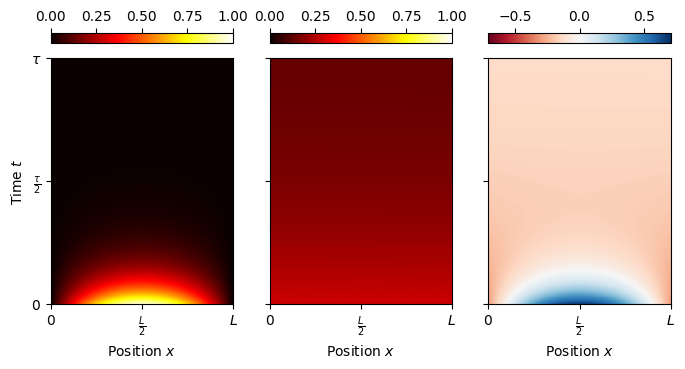

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

pcm = axes[0].pcolormesh(x, t, v := analytical_solution(x, t, params), shading="gouraud", cmap="hot", vmin=0, vmax=1)
fig.colorbar(pcm, ax=axes[0], location="top")

pcm = axes[1].pcolormesh(x, t, u, shading="gouraud", cmap="hot", vmin=0, vmax=1)
fig.colorbar(pcm, ax=axes[1], location="top")

pcm = axes[2].pcolormesh(x, t, v-u, shading="gouraud", cmap="RdBu", vmin=-abs(v-u).max(), vmax=abs(v-u).max())
fig.colorbar(pcm, ax=axes[2], location="top")

for i, ax in enumerate(axes):
    ax.set(xlim=(0, L), xlabel=r"Position $x$", xticks=[0, L/2, L], xticklabels=[r"$0$", r"$\frac{L}{2}$", r"$L$"])
    ax.set(ylim=(0, τ), yticks=[0, τ/2, τ], yticklabels=[r"$0$", r"$\frac{\tau}{2}$", r"$\tau$"])
    if i == 0:
        ax.set(ylabel=r"Time $t$")